# Problem Set 5

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")

## 1. Study of the historical data of Hang Seng Index Using Python

### a. Import the index data of `^HSI`

The data is more than 9k lines.

### b. Clean the data by removing the unwanted lines labeled by “null”.

In [2]:
df = pd.read_csv("^HSI.csv")
df.dropna(inplace=True)
df

,Date,Open,High,Low,Close,Adj Close,Volume0
0,1986-12-31,2568.300049,2568.300049,2568.300049,2568.300049,2568.300049,0.000000e+00
2,1987-01-02,2540.100098,2540.100098,2540.100098,2540.100098,2540.100098,0.000000e+00
3,1987-01-05,2552.399902,2552.399902,2552.399902,2552.399902,2552.399902,0.000000e+00
4,1987-01-06,2583.899902,2583.899902,2583.899902,2583.899902,2583.899902,0.000000e+00
5,1987-01-07,2607.100098,2607.100098,2607.100098,2607.100098,2607.100098,0.000000e+00
...,...,...,...,...,...,...,...
9091,2022-10-18,16860.199219,16914.580078,16558.410156,16914.580078,16914.580078,1.971282e+09
9092,2022-10-19,16805.910156,16923.119141,16508.369141,16511.279297,16511.279297,1.713975e+09
9093,2022-10-20,16230.790039,16452.970703,16010.719727,16280.219727,16280.219727,2.295269e+09
9094,2022-10-21,16331.110352,16359.040039,16137.179688,16211.120117,16211.120117,2.052413e+09


### c. Calculate the daily returns.

I choose `Adj Close` price of each day as the daily price, then calculate the daily returns with the definition:

$$
r(t)=\log\left(\frac{P(t+1)}{P(t)}\right)
$$

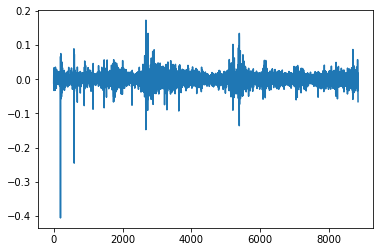

In [3]:
prices=df["Adj Close"].to_numpy()
r=np.log(prices[1:]/prices[:-1])
plt.plot(r)
plt.show()

### d. Calculate the normalized daily returns and separate the data into positive and negative returns.

1. Calculate the normalized daily returns

In [4]:
def normalize(x):
    return (x-np.mean(x))/np.std(x)

In [5]:
r_normed=normalize(r)
r_normed

array([-0.68614701,  0.28257527,  0.73639263, ..., -0.87243852,
       -0.27187612, -4.02069925])

2. separate the data into positive and negative returns

In [6]:
rp = r[r > 0]
rn = r[r < 0]

### e. Plot the cumulative return distribution for the positive and negative tails separately. 
The return values should be binned logarithmically.

In [7]:
def ecdf(rs:np.ndarray):
    return lambda x: np.mean(rs>x)

def power_law_fit(rs:np.ndarray,xs):
    y = np.array(list(map(ecdf(rs),xs)))
    X = sm.add_constant(np.log10(xs[y>0]))
    y = np.log10(y[y>0])

    mod = sm.OLS(y, X)
    results = mod.fit()
    a,b = results.params
    r2 = results.rsquared
    return {
        "α":-b,
        "c": a,
        "R2":r2
    }

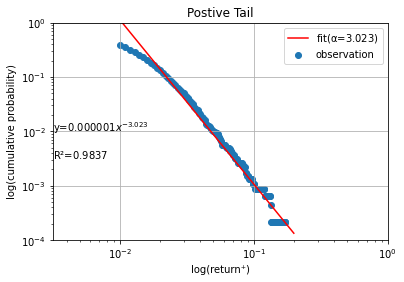

In [8]:
xs=np.arange(0.01,0.2,0.001)
alpha,c,R2=power_law_fit(rp,xs).values()
ys=list(map(ecdf(rp),xs))
yfits=10**c*xs**(-alpha)

plt.scatter(xs,ys,label="observation")
plt.plot(xs,yfits,label=f"fit(α=${alpha:.3f}$)",c="red")
plt.text(10**-2.5,10**-2,f"y=${10**c:.6f}x^{{{-alpha:.3f}}}$")
plt.text(10**-2.5,10**-2.5,f"R²=${R2:.4f}$")
plt.xlabel("log(return⁺)")
plt.ylabel("log(cumulative probability)")
plt.xscale("log")
plt.yscale("log")
plt.xlim((10**-2.5,10**0))
plt.ylim((10**-4,10**0))
plt.title("Postive Tail")
plt.grid(True)
plt.legend()
plt.show()

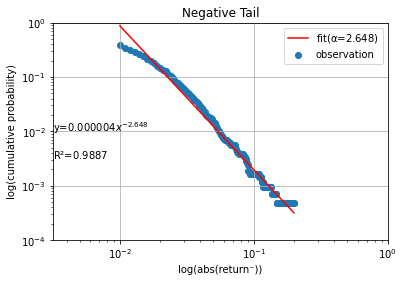

In [9]:
xs=np.arange(0.01,0.2,0.001)
absrn=np.abs(rn)
alpha,c,R2=power_law_fit(absrn,xs).values()
ys=list(map(ecdf(absrn),xs))
yfits=10**c*xs**(-alpha)

plt.scatter(xs,ys,label="observation")
plt.plot(xs,yfits,label=f"fit(α=${alpha:.3f}$)",c="red")
plt.text(10**-2.5,10**-2,f"y=${10**c:.6f}x^{{{-alpha:.3f}}}$")
plt.text(10**-2.5,10**-2.5,f"R²=${R2:.4f}$")
plt.xlabel("log(abs(return⁻))")
plt.ylabel("log(cumulative probability)")
plt.xscale("log")
plt.yscale("log")
plt.xlim((10**-2.5,10**0))
plt.ylim((10**-4,10**0))
plt.title("Negative Tail")
plt.grid(True)
plt.legend()
plt.show()

### f. Observe  whether  the  plots  obey  power  law  distributions.  If  so,  calculate  the  exponents  of  the power-law regime.

From the plots, we can claim that both positive and negative tail obey power law distributions.

The $\alpha_+=3.023$ is the exponents of positive tail and $\alpha_-=2.648$ is the exponents of negative tail.

## 2. Detrended Fluctuation Analysis of Hang Seng Index Using Python

### a. Read the data from the cleaned data file using Pandas.

In [10]:
df = pd.read_csv("^HSI.csv")
df = df[df["Adj Close"].notna()]
df

,Date,Open,High,Low,Close,Adj Close,Volume0
0,1986-12-31,2568.300049,2568.300049,2568.300049,2568.300049,2568.300049,0.000000e+00
2,1987-01-02,2540.100098,2540.100098,2540.100098,2540.100098,2540.100098,0.000000e+00
3,1987-01-05,2552.399902,2552.399902,2552.399902,2552.399902,2552.399902,0.000000e+00
4,1987-01-06,2583.899902,2583.899902,2583.899902,2583.899902,2583.899902,0.000000e+00
5,1987-01-07,2607.100098,2607.100098,2607.100098,2607.100098,2607.100098,0.000000e+00
...,...,...,...,...,...,...,...
9091,2022-10-18,16860.199219,16914.580078,16558.410156,16914.580078,16914.580078,1.971282e+09
9092,2022-10-19,16805.910156,16923.119141,16508.369141,16511.279297,16511.279297,1.713975e+09
9093,2022-10-20,16230.790039,16452.970703,16010.719727,16280.219727,16280.219727,2.295269e+09
9094,2022-10-21,16331.110352,16359.040039,16137.179688,16211.120117,16211.120117,2.052413e+09


### b. Extract the time series of the absolute returns from the column ‘Adj Close’ 

In [11]:
prices=df["Adj Close"].to_numpy()
ret=np.abs(np.log(prices[1:]/prices[:-1]))
ret

array([0.01104073, 0.00483057, 0.01226579, ..., 0.01409288, 0.00425342,
       0.06567318])

### c. Compute the average of the time series. 

In [12]:
avg = np.average(ret)
avg

0.010692097535708493

### d. Generate the series of cumulative sum, with each term subtracted by the average.

In [13]:
ret_c = ret-avg
ret_cumsum = np.cumsum(ret_c)
ret_cumsum

array([ 3.48634062e-04, -5.51289777e-03, -3.93920237e-03, ...,
       -4.85424084e-02, -5.49810824e-02,  7.27196081e-15])

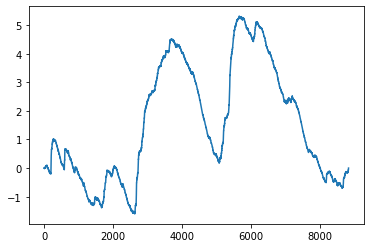

In [14]:
plt.plot(ret_cumsum)

### e. The Sliding Window Method
### f. For each segment starting at $𝑡_0$, compute the root-mean-square difference between the data points  and  the  local  trend.  

In [15]:
def εs(series, tau):
    T = len(series)
    t_end = T-tau+1

    x = np.arange(0, tau)
    x_mean = np.mean(x)
    x_var = np.var(x)

    ys = np.array([series[t:t+tau] for t in np.arange(0, t_end)])
    y2s = ys**2
    ysmean = np.mean(ys, axis=1)
    y_vars = np.var(ys, axis=1)
    xysmean = np.mean(ys*x, axis=1)
    return (y_vars-(xysmean-x_mean*ysmean)**2/x_var)**.5


def F(series, tau):
    return np.mean(εs(series, tau))


In [16]:
T = len(ret_cumsum)
xs = np.arange(round(np.log10(7), 1), round(np.log10(T-6), 1), 0.1)
taus = (10**xs).astype(int)
Fs = np.array([F(ret_cumsum, tau) for tau in taus])


### g. For  each  value  of  𝜏,  average  𝜀  over  all  samples  of  $𝑡_0$.  This  yields  the  result  𝐹(𝜏).  Plot  𝐹(𝜏) versus 𝜏 using logarithmic scales for both axes.

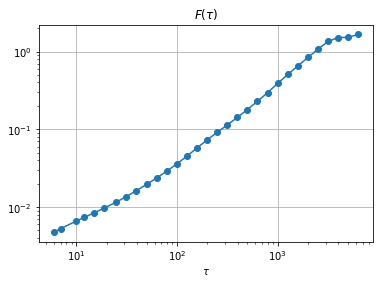

In [17]:
plt.plot(taus, Fs, 'o-')
plt.xlabel(r"$\tau$")
plt.xscale("log")
plt.yscale("log")
plt.title(r"$F(\tau)$")
plt.grid(True)
plt.show()


### h. To obtain the exponent 𝛼 in the relation 𝐹(𝜏) ∝ $\tau^\alpha$, discard the upper and lower parts of the data points that deviate from the power law and obtain the value of 𝛼.

In [18]:
cond=(taus>10)*(taus<=10**3.5)
X = sm.add_constant(np.log10(taus[cond]))
y = np.log10(Fs[cond])
mod = sm.OLS(y, X)
results = mod.fit()
c,alpha = results.params
R2 = results.rsquared

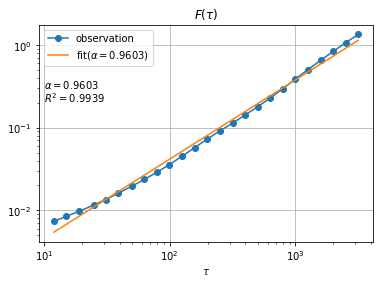

In [19]:
Ffits=10**c*(taus**alpha)

plt.plot(taus[cond], Fs[cond], 'o-',label="observation")
plt.plot(taus[cond], Ffits[cond], label=rf"fit($\alpha={alpha:.4f}$)")
plt.grid(True)
plt.xlabel(r"$\tau$")
plt.xscale("log")
plt.yscale("log")
plt.title(r"$F(\tau)$")
plt.text(10, 0.3, rf"$\alpha={alpha:.4f}$")
plt.text(10, 0.2, f"$R^2={R2:.4f}$")
plt.legend()
plt.show()


## 3. Power Spectral Density of Hang Seng Index Using Python

### a. Using the time series of the absolute returns of the Hang Seng Index obtained in the previous problem, plot the autocorrelation function as a function of time lag. 
Discard large values of time lag at which the autocorrelation function becomes too noisy.

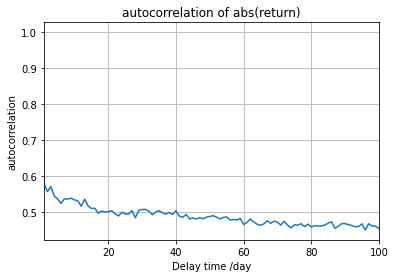

In [20]:
maxlags=100
ts,Cs,*_=plt.acorr(ret,maxlags=maxlags,usevlines=False,linestyle="-",marker=" ")
plt.title("autocorrelation of abs(return)")
plt.xlabel("Delay time /day")
plt.ylabel("autocorrelation")
plt.xlim([1,maxlags])
plt.grid(True)
plt.show()

### b. Plot the power spectral density 𝑆(𝑓) of the above autocorrelation function 
using logarithmic scales for both axes.

In [21]:
Ss=np.fft.rfft(Cs)
As=np.abs(Ss)
fs=np.arange(0,Ss.size)

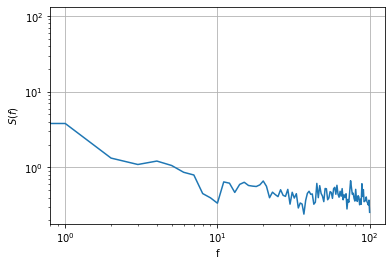

In [22]:
plt.plot(fs,As)
plt.grid(True)
plt.ylabel("$S(f)$")
plt.xlabel("f")
plt.yscale("log")
plt.xscale("log")
plt.show()

### c. For the linear part of the power spectral density plot, compute the exponent 𝛽 in the relation 𝑆(𝑓) ∝ $f^{\beta}$. 

In [23]:
def psd_fit(fs,As,cond):
    X = sm.add_constant(np.log10(fs[cond]))
    y = np.log10(As[cond])
    mod = sm.OLS(y, X)
    results = mod.fit()
    lnc, beta_ = results.params
    beta = -beta_
    R2 = results.rsquared
    return lnc,beta,R2

In [24]:
cond1=(fs >= 1)*(fs <= 10)
lnc1,beta1,R2_1=psd_fit(fs,As,cond1)
beta1

0.9087013784244521

$\beta_1$=0.9087013784244521

In [25]:
cond2=(fs >= 10)*(fs <= 100)
lnc2,beta2,R2_2=psd_fit(fs,As,cond2)
beta2

0.1391219942607358

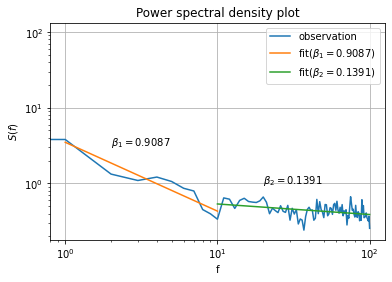

In [26]:
A1s=10**lnc1*fs**(-beta1)
A2s=10**lnc2*fs**(-beta2)

plt.plot(fs,As,label="observation")
plt.plot(fs[cond1],A1s[cond1],label=rf"fit($\beta_1={beta1:.4f}$)")
plt.plot(fs[cond2],A2s[cond2],label=rf"fit($\beta_2={beta2:.4f}$)")
plt.grid(True)
plt.ylabel("$S(f)$")
plt.xlabel("f")
plt.yscale("log")
plt.xscale("log")
plt.text(10**.3,10**.5,rf"$\beta_1={beta1:.4f}$")
plt.text(10**1.3,1,rf"$\beta_2={beta2:.4f}$")
plt.title("Power spectral density plot")
plt.legend()
plt.show()

### d. Verify whether the relation 𝛽 = 2𝛼 ― 1 is valid.

In [27]:
2*alpha-1

0.9205098400738079

In [28]:
beta1

0.9087013784244521

From above calculation, we obtain the value of two parameter:

$2\alpha-1$=0.9205098400738079

$\beta_1$=0.9087013784244521

These two values are quite close, so we claim that the relation $\beta=2\alpha-1$ is valid.